# 🧠 Rock Paper Scissors Classification with MobileNetV2

This notebook demonstrates training a transfer learning model using MobileNetV2 on the Rock-Paper-Scissors dataset from Hugging Face. It includes data preprocessing, augmentation, class balancing, and fine-tuning to avoid overfitting.

## 1. Install and Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from datasets import load_dataset
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


c:\Users\shailshree\Desktop\Academics\3rd year\computervision\coursework\app\rock_paper_scissor_game_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Extract Dataset from Hugging Face

In [ ]:

dataset = load_dataset("Javtor/rock-paper-scissors")
label_names = dataset['train'].features['label'].names

base_dir = "dataset"
splits = ['train', 'test']

def save_images_to_folder(split_name):
    split_dataset = dataset[split_name]
    for idx, sample in enumerate(split_dataset):
        label = label_names[sample['label']]
        image = sample['image']
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        save_dir = os.path.join(base_dir, split_name, label)
        os.makedirs(save_dir, exist_ok=True)
        image_path = os.path.join(save_dir, f"{split_name}_{label}_{idx}.jpg")
        image.save(image_path)

for split in splits:
    save_images_to_folder(split)

print("✅ Dataset saved in dataset/train and dataset/test.")


## 3. Load Dataset with Augmentation

In [2]:

train_dir = 'dataset/train'
test_dir = 'dataset/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.7, 1.3],
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32,
    class_mode='categorical', subset='training'
)

val_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32,
    class_mode='categorical', subset='validation'
)

test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)


Found 2016 images belonging to 3 classes.
Found 504 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


## 4. Compute Class Weights

In [3]:

y_train = train_gen.classes
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))


## 5. Define Model Architecture (Transfer Learning with Dropout)

In [4]:

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


## 6. Train Top Layers

In [5]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)
]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)


c:\Users\shailshree\Desktop\Academics\3rd year\computervision\coursework\app\rock_paper_scissor_game_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.6635 - loss: 0.7519

63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6658 - loss: 0.7472 - val_accuracy: 0.9385 - val_loss: 0.1571 - learning_rate: 0.0010
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 841ms/step - accuracy: 0.9576 - loss: 0.1264 - val_accuracy: 0.9008 - val_loss: 0.3089 - learning_rate: 0.0010
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.9592 - loss: 0.1044

63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 948ms/step - accuracy: 0.9594 - loss: 0.1040 - val_accuracy: 0.9504 - val_loss: 0.1592 - learning_rate: 5.0000e-04


## 7. Fine-Tune Last 20 Layers

In [6]:

base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 870ms/step - accuracy: 0.8662 - loss: 0.3335 - val_accuracy: 0.9286 - val_loss: 0.2318 - learning_rate: 1.0000e-05
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 809ms/step - accuracy: 0.9508 - loss: 0.1476 - val_accuracy: 0.9067 - val_loss: 0.2697 - learning_rate: 1.0000e-05
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 816ms/step - accuracy: 0.9527 - loss: 0.1358 - val_accuracy: 0.9246 - val_loss: 0.2337 - learning_rate: 5.0000e-06


## 8. Plot Accuracy and Loss (Smoothed)

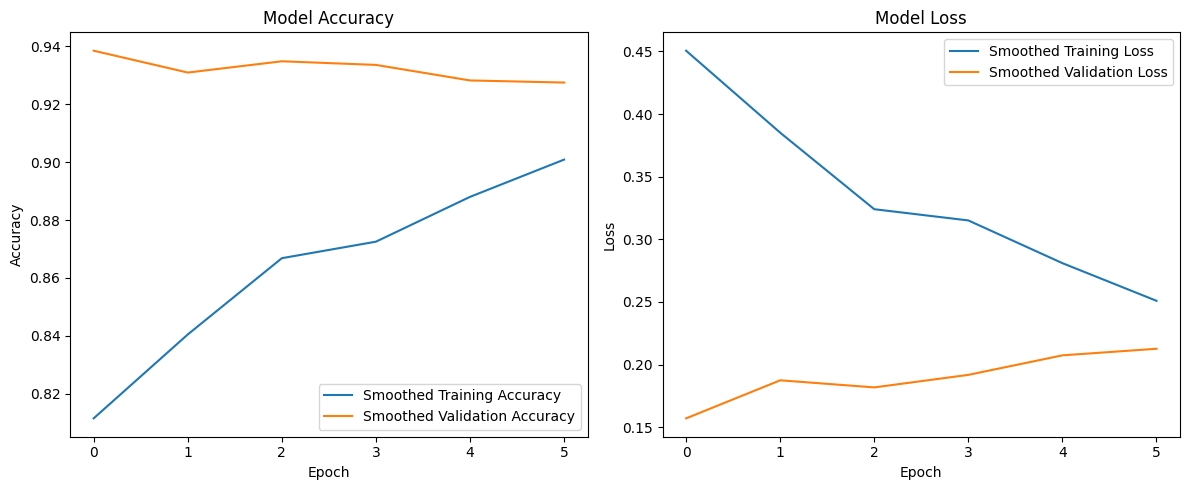

In [7]:

def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def combine_history(h1, h2):
    combined = {}
    for k in h1.history:
        combined[k] = h1.history[k] + h2.history.get(k, [])
    return combined

full_history = combine_history(history, fine_tune_history)

smooth_acc = smooth_curve(full_history['accuracy'])
smooth_val_acc = smooth_curve(full_history['val_accuracy'])
smooth_loss = smooth_curve(full_history['loss'])
smooth_val_loss = smooth_curve(full_history['val_loss'])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(smooth_acc, label='Smoothed Training Accuracy')
plt.plot(smooth_val_acc, label='Smoothed Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(smooth_loss, label='Smoothed Training Loss')
plt.plot(smooth_val_loss, label='Smoothed Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
